### Non-Local Means Comparison

The purpose of this notebook is to create a baseline similarity comparison between the low-level intensity images using non-local means image processing algorithm with the high intensity cell images.

Model repo: http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_nl_means

Paper: http://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf

In [1]:
import numpy as np
import skimage 
import matplotlib.pyplot as plt
import pickle as pkl
import statistics

from cellvision_lib import get_model_data_splits
from scipy.stats import entropy
from skimage import data, img_as_float, img_as_ubyte, io
from skimage.measure import compare_ssim
from skimage.measure import compare_mse, compare_nrmse
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
import glob
import os 
import statistics
import pickle as pkl


def get_pix_fname(base_dir, ref_fname, _channel, mode, comp):
        fname = os.path.basename(comp)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
        z_depth = fname[start_z_index:end_index]
        new_comp_path = '{}/A/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        new_ref_path = '{}/B/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        return new_comp_path, new_ref_path 

# channels = list(range(2,6))
for channel in channels:
    folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'

    train, test, val = get_model_data_splits(folder_path, 
                                          channel = channel, 
                                          train_pp = .6, 
                                          test_pp = .2, 
                                          val_pp = .2, 
                                          seed = 1)   
    print('\nRunning channel '+ str(channel))
    channel_ssim = []
    channel_mse = []
    pix_folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel{}_100'.format(channel)
    for i, (comp2, ref) in enumerate(val):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "val", comp2)
        skimage_comp = io.imread(new_comp_path)
        skimage_ref = io.imread(new_ref_path)
        
        fake_high_mse = compare_nrmse(skimage_ref, skimage_comp)
        channel_mse.append( fake_high_mse )
        
#         _min = skimage_ref.min()
#         _max = skimage_ref.max()

#         fake_high_ssim = compare_ssim(skimage_ref.astype(np.float), skimage_comp.astype(np.float), data_range=_max-_min)
#         channel_ssim.append( fake_high_ssim )
        
#     print('    mean ssim: ' + str(statistics.mean(channel_ssim)))
    print('    mean mse: ' + str(statistics.mean(channel_mse)))
    print('Writing the baseline for channel {}'.format(channel))
    write_path = 'sum_stats_channel{}'.format(channel)
    pkl.dump(channel_ssim, open('new_baseline_ssim_' + write_path, "wb"))
    pkl.dump(channel_mse, open('new_baseline_mse_' + write_path, "wb"))

#     print(fake_high_ssim)
#     raise
    
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample110_channel6_z2.tif'
# path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_100/val_latest/images/sample97_channel1_z9_fake_B.png'
# skimage_original = io.imread(path_to_data).astype(np.uint)
# result_dir = '{}/cellvision_channel{}_{}/val_latest/images'.format(result_path, channel, sample_size)
# real_path_low = '{}/*_real_A.png'.format(result_dir)
# real_low_imgs = glob.glob(real_path_low)
# channel_ssim


Running channel 1
    mean mse: 0.8857866551626357
Writing the baseline for channel 1

Running channel 2
    mean mse: 0.8500580715177631
Writing the baseline for channel 2

Running channel 3
    mean mse: 0.4997106074610476
Writing the baseline for channel 3

Running channel 4
    mean mse: 0.2188084837895147
Writing the baseline for channel 4

Running channel 5
    mean mse: 0.09159356800744162
Writing the baseline for channel 5


In [2]:
out_path = '/home/dg3047/capstone/CellVision/notebooks'

channels = list(range(1,6))
# sample_sizes =[100, 500, 1000]

results_dirs = []
ssim_means = []
ssim_stds = []
for channel in channels:
    ssim_path = '{}/baseline_ssim_sum_stats_channel{}'.format(out_path,channel)
    with open(ssim_path, 'rb') as pickle_file:
        channel_ssim = pkl.load(pickle_file)
        ssim_std = statistics.stdev(channel_ssim)
        ssim_mean = statistics.mean(channel_ssim)
        ssim_means.append(ssim_mean)
        ssim_stds.append(ssim_std)

mse_means = []
mse_stds = []
for channel in channels:
    mse_path = '{}/baseline_mse_sum_stats_channel{}'.format(out_path,channel)
    with open(mse_path, 'rb') as pickle_file:
        channel_mse = pkl.load(pickle_file)
        mse_std = statistics.stdev(channel_mse)
        mse_mean = statistics.mean(channel_mse)
        mse_means.append(mse_mean)
        mse_stds.append(mse_std)
        
nmse_means = []
nmse_stds = []
for channel in channels:
    nmse_path = '{}/new_baseline_mse_sum_stats_channel{}'.format(out_path,channel)
    with open(nmse_path, 'rb') as pickle_file:
        channel_nmse = pkl.load(pickle_file)
        nmse_std = statistics.stdev(channel_nmse)
        nmse_mean = statistics.mean(channel_nmse)
        nmse_means.append(nmse_mean)
        nmse_stds.append(nmse_std)

print(len(mse_means))
print(mse_means)
print(nmse_means)
ssim_means

5
[6760597.741654361, 6255314.42175066, 2176880.5938983513, 416320.7456069251, 68434.07397303164]
[0.8857866551626357, 0.8500580715177631, 0.4997106074610476, 0.2188084837895147, 0.09159356800744162]


[0.2584401908702972,
 0.3162300935056593,
 0.5801115181626371,
 0.6609771765746856,
 0.6656509244974465]

No handles with labels found to put in legend.


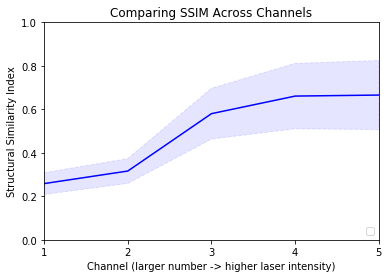

In [17]:
# Comparing SSIM
import operator
from numpy import array
ssim_means = array(ssim_means)
ssim_stds = array(ssim_stds)

plt.plot(list(range(1, 6)), ssim_means[0:5], color='blue') 

plt.fill_between(list(range(1, 6)), ssim_means[0:5] + ssim_stds[0:5], np.subtract(ssim_means[0:5],ssim_stds[0:5]), 
                 color="blue", linestyle="--", alpha=0.1)


plt.title('Comparing SSIM Across Channels')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('Structural Similarity Index')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [10]:
mse_path = '{}/new_baseline_mse_sum_stats_channel4'.format(out_path,channel)
with open(mse_path, 'rb') as pickle_file:
    channel_mse = pkl.load(pickle_file)
print(len(channel_mse))


1383


No handles with labels found to put in legend.


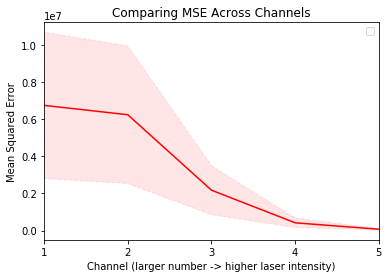

In [4]:
# Comparing MSE
import operator
from numpy import array
mse_means = array(mse_means)
mse_stds = array(mse_stds)

plt.plot(list(range(1, 6)), mse_means[0:5], color='red') 

plt.fill_between(list(range(1, 6)), mse_means[0:5] + mse_stds[0:5], np.subtract(mse_means[0:5],mse_stds[0:5]), 
                 color="red", linestyle="--", alpha=0.1)


plt.title('Comparing MSE Across Channels')
plt.legend(loc = 'upper right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('Mean Squared Error')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

No handles with labels found to put in legend.


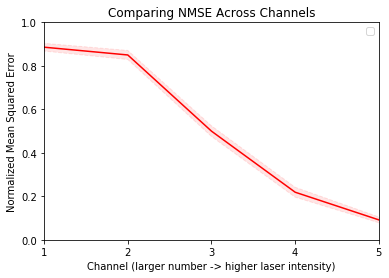

In [7]:
# Comparing MSE
import operator
from numpy import array
nmse_means = array(nmse_means)
nmse_stds = array(nmse_stds)

plt.plot(list(range(1, 6)), nmse_means[0:5], color='red') 

plt.fill_between(list(range(1, 6)), nmse_means[0:5] + nmse_stds[0:5], np.subtract(nmse_means[0:5],nmse_stds[0:5]), 
                 color="red", linestyle="--", alpha=0.1)


plt.title('Comparing NMSE Across Channels')
plt.legend(loc = 'upper right')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('Normalized Mean Squared Error')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [9]:
print(ssim_means)
print(ssim_stds)
print(mse_means)
print(mse_stds)
print(nmse_means)
print(nmse_stds)

[0.2584401908702972, 0.3162300935056593, 0.5801115181626371, 0.6609771765746856, 0.6656509244974465]
[0.050047089138993105, 0.057000087922160506, 0.11692778666059618, 0.15052336860017632, 0.15905146592449662]
[6760597.74165436 6255314.42175066 2176880.59389835  416320.74560693
   68434.07397303]
[3951262.31127398 3716853.13171936 1324520.29110548  255740.46206895
   36473.23437125]
[0.88578666 0.85005807 0.49971061 0.21880848 0.09159357]
[0.01785047 0.02095006 0.02454153 0.02281621 0.01335153]


In [2]:
import glob
import os

MAX_DEPTH = 100
NUM_SAMPLES = 109

folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

def get_comp_path_tuples(data_dir, comp_channel, reference_channel=6):
    comps = []
    for i in range(1, NUM_SAMPLES):
        for z in range(1, MAX_DEPTH):
            ref_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, reference_channel, z)
            comp_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, comp_channel, z)
            if not os.path.isfile(ref_path) or not os.path.isfile(comp_path):
                continue
            comps.append( (comp_path, ref_path) )
    return comps

channel1_comps = get_comp_path_tuples(folder_path, 1)
channel2_comps = get_comp_path_tuples(folder_path, 2)
channel3_comps = get_comp_path_tuples(folder_path, 3)
channel4_comps = get_comp_path_tuples(folder_path, 4)
channel5_comps = get_comp_path_tuples(folder_path, 5)

print(len(channel1_comps))

10488


In [18]:
src_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'
channels = list(range(1,6))
all_img_pairs = []
for channel in channels:
    train, test, val = train_test_val(src_path, 
                                      channels = channel, 
                                      train_pp = .8, 
                                      test_pp = .1, 
                                      val_pp = .1, 
                                      set_seed = 1)
    all_img_pairs.append( train[0:200] )
print(all_img_pairs[4][0:2])
print(all_img_pairs[1][0:2])

[['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel5_z3.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel6_z3.tif'], ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel5_z2.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel6_z2.tif']]
[['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel2_z3.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel6_z3.tif'], ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel2_z2.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel6_z2.tif']]


In [21]:
# Store denoised images
import pickle as pkl
import os
write_dir = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-denoised/'
print(len(all_img_pairs))
print(len(all_img_pairs[0]))
# print(all_img_pairs)
for img_channel in all_img_pairs:
    for img in img_channel:
        channel_img_str = img[0]
        channel_img = io.imread(channel_img_str).astype(np.uint)
        channel_img_ft = img_as_float(channel_img)
        channel_img_dn = denoise_nl_means(channel_img_ft)
        fname = os.path.basename(channel_img_str)
        pkl.dump(channel_img_dn, open(write_dir + fname, "wb"))

    

5
200


In [14]:
# Channel 1 comps
import pickle as pkl
from time import time

def process_channel_comps(image_paths, channel, test=''):
    print()
    print("Beginning comp process for channel {}".format(channel))
    comps = []
    for comp_path, ref_path in image_paths:
        comp = io.imread(comp_path).astype(np.uint)
        ref = io.imread(ref_path).astype(np.uint)
        comp_ft = img_as_float(comp)
        ref_ft = img_as_float(ref)w
        channel_mse = compare_mse(comp, ref)
        _min = ref_ft.min()
        _max = ref_ft.max()
        channel_ssim = compare_ssim(comp_ft, ref_ft, data_range=_max-_min)
        denoised_comp = denoise_nl_means(comp_ft)
        channel_dn_mse = compare_mse(denoised_comp, ref_ft)
        channel_dn_ssim = compare_ssim(denoised_comp, ref_ft, data_range=_max-_min)
        comps.append( (comp_path, ref_path, channel_mse, channel_ssim, channel_dn_mse, channel_dn_ssim) )
    out_path = "outputs/baseline_channel{}{}".format(channel,test)
    print("Dumping pickled results into {}".format(out_path))
    pkl.dump(comps, open(out_path, "wb"))

start = time()
process_channel_comps(channel1_comps[0:300], 1, test='')
process_channel_comps(channel2_comps[0:300], 2, test='')
process_channel_comps(channel3_comps[0:300], 3, test='')
process_channel_comps(channel4_comps[0:300], 4, test='')
process_channel_comps(channel5_comps[0:300], 5, test='')
end = time()
print("Elapsed time: {} seconds".format(round(end - start, 2)))


Beginning comp process for channel 1
Dumping pickled results into outputs/baseline_channel1

Beginning comp process for channel 2
Dumping pickled results into outputs/baseline_channel2

Beginning comp process for channel 3
Dumping pickled results into outputs/baseline_channel3

Beginning comp process for channel 4
Dumping pickled results into outputs/baseline_channel4

Beginning comp process for channel 5
Dumping pickled results into outputs/baseline_channel5
Elapsed time: 2711.28 seconds


In [15]:
channel_comps = []
load_channels = range(1,6)
for i in load_channels:  
    with open('outputs/baseline_channel{}'.format(i), 'rb') as pickle_file:
        channel_scores = pkl.load(pickle_file)
        channel_comps.append(channel_scores)

In [16]:
print(channel_comps[1][0])

('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel2_z1.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z1.tif', 20511113.88896942, 0.2965951636780404, 6.028695810753086e-32, 0.2985823346768401)


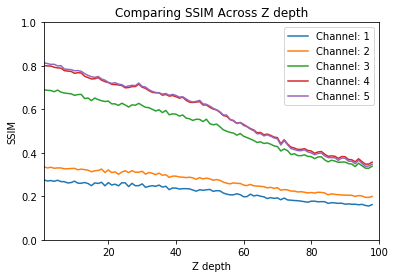

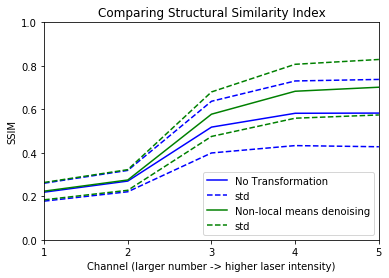

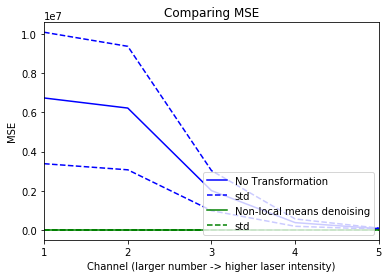

In [17]:
import statistics

z_means_idx2 = {}

metrics_tracker = {
    'z_means_idx' : {},
    'mse_means': [],
    'mse_stds' : [],
    'ssim_means' : [],
    'ssim_stds' : [],
    'mse_means_dn' : [],
    'mse_stds_dn' : [],
    'ssim_means_dn' : [],
    'ssim_stds_dn' : []
}

for i, channel in enumerate(channel_comps):
    mse = [metric[2] for metric in channel]
    mse_std = statistics.stdev(mse)
    mse_mean = statistics.mean(mse)
    metrics_tracker['mse_means'] = metrics_tracker['mse_means'] + [mse_mean]
    metrics_tracker['mse_stds'] = metrics_tracker['mse_stds'] + [mse_std]
    
    ssim = [metric[3] for metric in channel]
    ssim_std = statistics.stdev(ssim)
    ssim_mean = statistics.mean(ssim)
    metrics_tracker['ssim_means'] = metrics_tracker['ssim_means'] + [ssim_mean]
    metrics_tracker['ssim_stds'] = metrics_tracker['ssim_stds'] + [ssim_std]
    
    mse_dn = [metric[4] for metric in channel]
    mse_dn_std = statistics.stdev(mse_dn)
    mse_dn_mean = statistics.mean(mse_dn)
    metrics_tracker['mse_means_dn'] = metrics_tracker['mse_means_dn'] + [mse_dn_mean]
    metrics_tracker['mse_stds_dn'] = metrics_tracker['mse_stds_dn'] + [mse_dn_std]
    
    ssim_dn = [metric[5] for metric in channel]
    ssim_dn_std = statistics.stdev(ssim_dn)
    ssim_dn_mean = statistics.mean(ssim_dn)
    metrics_tracker['ssim_means_dn'] = metrics_tracker['ssim_means_dn'] + [ssim_dn_mean]
    metrics_tracker['ssim_stds_dn'] = metrics_tracker['ssim_stds_dn'] + [ssim_dn_std]
    
#     z_means_idx2 = {}
    for metric in channel:
        z_idx = metric[0].find('_z')
        z_val = metric[0][z_idx + 2:-4]
        key = str(i + 1) + '_' + str(z_val)
        if key not in z_means_idx2:
            z_means_idx2[key] = [metric[3]]
        else:
            z_means_idx2[key] = z_means_idx2[key] + [metric[3]]

for key, val in z_means_idx2.items():
    z_means_idx2[key] = statistics.mean(val)
# print(z_means_idx2)
# print(metrics_tracker)
# Comparing Structural Similarity Index for denoising
MAX_DEPTH = 99
for i in range(1,6):
    channel_z_means = []
    for y in range(1,MAX_DEPTH):
        key = str(i) + '_' + str(y)
        channel_z_means.append(z_means_idx2[key])
    plt.plot(list(range(1, MAX_DEPTH)), channel_z_means, label="Channel: {}".format(i)) 

plt.title('Comparing SSIM Across Z depth')
plt.legend(loc = 'upper right')
plt.ylim([0, 1])
plt.xlim([1, 100])
# plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Z depth')
plt.show()
# print(z_means_idx.keys())
# print(z_means_idx['5_30'])   


# Comparing Structural Similarity Index for denoising
plt.plot(list(range(1, 6)), metrics_tracker['ssim_means'], label="No Transformation", color='blue') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['ssim_means'], metrics_tracker['ssim_stds'])], 
         label="std",
         linestyle='--',
         color='blue') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['ssim_means'], metrics_tracker['ssim_stds'])], 
         linestyle='--',
         color='blue') 

plt.plot(list(range(1, 6)), metrics_tracker['ssim_means_dn'], label="Non-local means denoising", color='green') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['ssim_means_dn'], metrics_tracker['ssim_stds_dn'])], 
         label="std",
         linestyle='--',
         color='green') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['ssim_means_dn'], metrics_tracker['ssim_stds_dn'])], 
         linestyle='--',
         color='green') 

plt.title('Comparing Structural Similarity Index')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

# Comparing MSE for denoising
plt.plot(list(range(1, 6)), metrics_tracker['mse_means'], label="No Transformation", color='blue') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['mse_means'], metrics_tracker['mse_stds'])], 
         label="std",
         linestyle='--',
         color='blue') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['mse_means'], metrics_tracker['mse_stds'])], 
         linestyle='--',
         color='blue') 

plt.plot(list(range(1, 6)), metrics_tracker['mse_means_dn'], label="Non-local means denoising", color='green') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(metrics_tracker['mse_means_dn'], metrics_tracker['mse_stds_dn'])], 
         label="std",
         linestyle='--',
         color='green') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(metrics_tracker['mse_means_dn'], metrics_tracker['mse_stds_dn'])], 
         linestyle='--',
         color='green') 

plt.title('Comparing MSE')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('MSE')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()
    


In [ ]:
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009/test data_1_MMStack_Undefined1.ome.tif'
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample28_channel1_z12.tif'
imsk = io.imread(path_to_data)
imsk.shape

In [ ]:
# Convert everything to scaled floating values
scaled_imgs_1 = []
scaled_imgs_2 = []
scaled_imgs_3 = []
scaled_imgs_4 = []
scaled_imgs_5 = []
scaled_imgs_6 = []
for i in range(0,imsk.shape[0], 7):
    scaled_imgs_1.append(img_as_float(imsk[i,:,:].astype(np.uint)))
    scaled_imgs_2.append(img_as_float(imsk[i+1,:,:].astype(np.uint)))
    scaled_imgs_3.append(img_as_float(imsk[i+2,:,:].astype(np.uint)))
    scaled_imgs_4.append(img_as_float(imsk[i+3,:,:].astype(np.uint)))
    scaled_imgs_5.append(img_as_float(imsk[i+4,:,:].astype(np.uint)))
    scaled_imgs_6.append(img_as_float(imsk[i+5,:,:].astype(np.uint)))
print(scaled_imgs_1[0])
# print(scaled_imgs_2[0])

In [ ]:
# for i in range(0,20,10):
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(scaled_imgs_2[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_3[0]);
ax[2].axis('off')
ax[3].imshow(scaled_imgs_4[0]);
ax[3].axis('off')
ax[4].imshow(scaled_imgs_6[0]);
ax[4].axis('off')
plt.title('z = '+str(1))
plt.show()

In [ ]:
_min = scaled_imgs[5].min()
_max = scaled_imgs[5].max()
print(ssim(scaled_imgs[0],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[1],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[2],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[3],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[4],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[5],scaled_imgs[5],data_range=_max-_min))
print(len(scaled_imgs))

In [ ]:
print(len(scaled_imgs_4))

In [ ]:
denoised_imgs_1 = []
denoised_imgs_2 = []
denoised_imgs_3 = []
denoised_imgs_4 = []
denoised_imgs_5 = []
denoised_imgs_6 = []
for i in range(0,5):
    denoised_imgs_1.append(denoise_nl_means(scaled_imgs_1[i]))
    denoised_imgs_2.append(denoise_nl_means(scaled_imgs_2[i]))
    denoised_imgs_3.append(denoise_nl_means(scaled_imgs_3[i]))
    denoised_imgs_4.append(denoise_nl_means(scaled_imgs_4[i]))
    denoised_imgs_5.append(denoise_nl_means(scaled_imgs_5[i]))
    denoised_imgs_6.append(denoise_nl_means(scaled_imgs_6[i]))
    print(i)
print(denoised_imgs_1[0])

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(denoised_imgs_1[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_5[0]);
ax[2].axis('off')
ax[3].imshow(denoised_imgs_5[0]);
ax[3].axis('off')
plt.title('z = '+str(1))
plt.show()

print(ssim(denoised_imgs_4[0],scaled_imgs_5[0],data_range=_max-_min))

In [ ]:
original_ssim_1 = []
nl_ssim_1 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_1.append(ssim(scaled_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_1.append(ssim(denoised_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))

original_ssim_4 = []
nl_ssim_4 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_4.append(ssim(scaled_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_4.append(ssim(denoised_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_4)/len(original_ssim_4))
print(sum(nl_ssim_4)/len(nl_ssim_4))

# plt.plot(list(range(0, 5)), original_ssim, label="No change") 
# plt.plot(list(range(0, 5)), nl_ssim, label="Non-local means denoising") 

# plt.title('Comparing Structural Similarity Index')
# plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
# plt.xlim([0, 4])
# plt.axes().set_xticks(list(range(0, 5)), minor=False)

# plt.ylabel('SSIM')
# plt.xlabel('Laser Intensity')
# plt.show()

    
    

In [ ]:
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))

(512, 512)
(512, 512)
(512, 512, 3)
(512, 512)


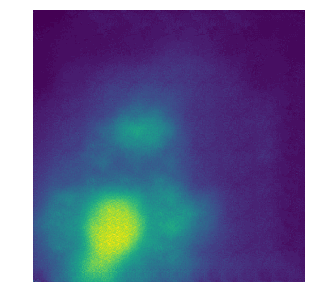

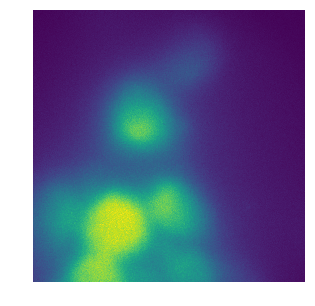

In [3]:
import cv2
from skimage import img_as_ubyte, io

path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel6_z9.tif'
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/B/val/sample67_channel1_z75.jpg'
skimage_original = io.imread(path_to_data).astype(np.uint)
print(skimage_original.shape)
cv_original = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
print(cv_original.shape)

# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/val/sample114_channel1_z10.jpg'
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
# fold_out = io.imread(path_to_data)
# print(fold_out.shape)
# cv_fold = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
# print(cv_fold.shape)

path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_500/val_latest/images/sample31_channel1_z9_fake_B.png'
result_io = io.imread(path_to_data)
print(result_io.shape)
im_A = cv2.imread(path_to_data)
result_io_sk = cv2.imread(path_to_data, cv2.IMREAD_GRAYSCALE)
print(result_io_sk.shape)

# print(imsk_B.shape)
# print(im_A.shape)

# fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
# fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
# ax[0].imshow(cv_original);
# ax[0].axis('off')
# ax[1].imshow(fold_out);
# ax[1].axis('off')
# ax[2].imshow(fold_out);
# ax[2].axis('off')
# ax[3].imshow(result_io_sk);
# ax[3].axis('off')
# plt.show()


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
ax.imshow(result_io_sk);
ax.axis('off')
plt.show()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
ax.imshow(skimage_original);
ax.axis('off')
plt.show()

# low_high_ssim = compare_ssim(skimage_original, img_as_uint(result_io_sk))
# low_high_ssim

# As seen sample71_channel1_z9, sample6_channel1_z9

# Good ones: sample31_channel6_z9

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

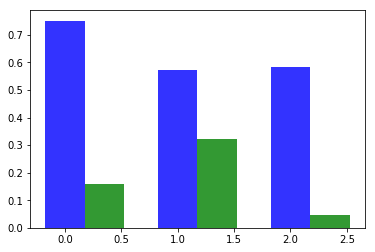

In [21]:
import numpy as np
import matplotlib.pyplot as plt

#BARCHART DATA -- CHANNEL 1

#CARE
care_ssim_pred_mean = 0.751355296611922
care_mse_pred_mean = 0.16050278070677332

#PIX2Pix channel 1, sample 500
p2p_ssim_pred_mean = 0.57204
p2p_mse_pred_mean = 0.322105552366507

#UNET
unet_ssim_pred_mean = 0.5831881658009966
unet_mse_pred_mean = 0.04760294572818723

SSIM_original_mean = 0.2584401908702972
MSE_original_mean = 0.8857866551626357
 
# data to plot
n_groups = 3
means_ssim = (care_ssim_pred_mean, p2p_ssim_pred_mean, unet_ssim_pred_mean)
means_nsme = (care_mse_pred_mean, p2p_mse_pred_mean, unet_mse_pred_mean)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_ssim, bar_width,
                 alpha=opacity,
                 color='b',
                 label='SSIM')
 
rects2 = plt.bar(index + bar_width, means_nsme, bar_width,
                 alpha=opacity,
                 color='g',
                 label='NMSE')

# fig, ax = plt.subplots()
# ax.bar(y_pos, performance, align='center', alpha=0.5, color='y', label='Mean Predicted NMSE')

objects = ('CARE Model', 'Pix2Pix', 'UNet')
y_pos = np.arange(len(objects))
performance = [care_mse_pred_mean,p2p_mse_pred_mean,unet_mse_pred_mean]
ax.plot(y_pos, MSE_original_mean, "k--", label='Validation MSE Baseline')
 
plt.xlabel('Person')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('CARE Model', 'Pix2Pix Model', 'UNet'))
plt.ylim([0, 1])
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()